In [5]:
!pip install cartopy


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


/tmp/ipykernel_409356/3352800590.py:155: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 0.95]) # Ajustar layout para espacio 'medio' para colorbar y título


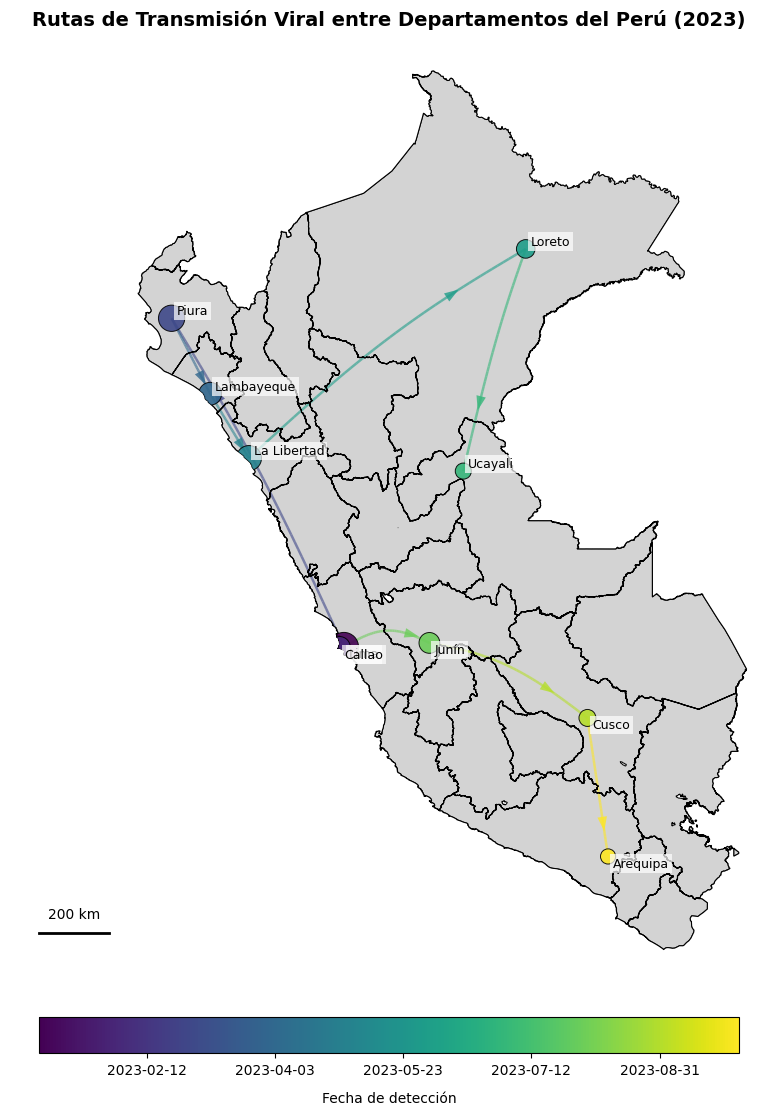

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import pandas as pd
import numpy as np
from matplotlib.patches import Circle, PathPatch
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from matplotlib.colorbar import ColorbarBase
from matplotlib.path import Path
from shapely.geometry import MultiPolygon

# Configuración inicial
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'

# Datos de ejemplo para Perú:
data = {
    'departamento': ['Lima', 'Callao', 'Piura', 'Lambayeque', 'La Libertad',
                    'Loreto', 'Ucayali', 'Junín', 'Cusco', 'Arequipa'],
    'capital_lat': [-12.0464, -12.0500, -5.1945, -6.7669, -8.1091,
                   -3.7491, -8.3791, -11.9592, -13.5226, -16.4090],
    'capital_lon': [-77.0428, -77.1333, -80.6328, -79.8286, -79.0215,
                   -73.2532, -74.5539, -75.2606, -71.9673, -71.5375],
    'date': ['2023-01', '2023-02', '2023-03', '2023-04', '2023-05',
             '2023-06', '2023-07', '2023-08', '2023-09', '2023-10'],
    'cases': [150, 80, 120, 90, 110, 60, 45, 75, 50, 40],
    'origin': [None, 'Lima', 'Lima', 'Piura', 'Lambayeque',
              'La Libertad', 'Loreto', 'Lima', 'Junín', 'Cusco']
}

df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Cargar shapefile y crear máscara para Perú
shapefile = '../data/DEPARTAMENTOS_inei_geogpsperu_suyopomalia/DEPARTAMENTOS_inei_geogpsperu_suyopomalia.shp'
peru_shape = list(Reader(shapefile).geometries())
peru_feature = ShapelyFeature(peru_shape, ccrs.PlateCarree(), facecolor='lightgray')

# Crear figura
fig = plt.figure(figsize=(14, 12), facecolor='white')
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Configurar límites usando el contorno de Perú:
paths = []
for geom in peru_shape:
    if geom.geom_type == 'MultiPolygon':
        for polygon in geom.geoms:
            exterior_coords = np.array(polygon.exterior.coords)[:, :2]
            paths.append(Path(exterior_coords))
    else:
        exterior_coords = np.array(geom.exterior.coords)[:, :2]
        paths.append(Path(exterior_coords))

peru_path = Path.make_compound_path(*paths)
patch = PathPatch(peru_path, transform=ax.transData, facecolor='none', edgecolor='none')
ax.add_patch(patch)
ax.set_boundary(peru_path)

# Ajustar extensión con margen
ax.set_extent([-84, -68.2, -20.2, 0.2], crs=ccrs.PlateCarree())

# Añadir territorio peruano
ax.add_feature(peru_feature, edgecolor='black', linewidth=0.7)

# Configurar colores por fecha
date_norm = mdates.date2num(df['date'])
norm = mcolors.Normalize(vmin=date_norm.min(), vmax=date_norm.max())
cmap = plt.get_cmap('viridis')

# Diccionario de coordenadas
depto_coords = {row['departamento']: (row['capital_lon'], row['capital_lat']) for _, row in df.iterrows()}

# Función para líneas curvas
def curved_line(start, end, curvature=0.3):
    x = np.linspace(start[0], end[0], 50)
    y = np.linspace(start[1], end[1], 50)
    dist = np.sqrt((end[0]-start[0])**2 + (end[1]-end[1])**2) # Corregido: usar end[1] para y final
    if dist > 1:
        y += curvature * np.sin(np.pi * np.linspace(0, 1, 50))
    return x, y

# Dibujar conexiones entre departamentos
for _, row in df.iterrows():
    if pd.notna(row['origin']) and row['origin'] in depto_coords:
        start = depto_coords[row['origin']]
        end = (row['capital_lon'], row['capital_lat'])
        x, y = curved_line(start, end)

        segments = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([segments[:-1], segments[1:]], axis=1)

        lc = LineCollection(segments, colors=[cmap(norm(mdates.date2num(row['date'])))],
                           alpha=0.6, linewidths=1.8, zorder=2)
        ax.add_collection(lc)

        # Flecha direccional
        arrow_pos = int(0.7 * 49)
        ax.arrow(x[arrow_pos], y[arrow_pos],
                 x[arrow_pos+1]-x[arrow_pos],
                 y[arrow_pos+1]-y[arrow_pos],
                 shape='full', lw=0, head_width=0.2, head_length=0.3,
                 fc=cmap(norm(mdates.date2num(row['date']))),
                 ec=cmap(norm(mdates.date2num(row['date']))), alpha=0.8, zorder=3)

# Dibujar puntos de brote (asegurando visibilidad)
for _, row in df.iterrows():
    color = cmap(norm(mdates.date2num(row['date'])))
    size = np.sqrt(row['cases']) * 5

    circle = Circle((row['capital_lon'], row['capital_lat']), size/200,
                   color=color, alpha=0.9, ec='black', lw=0.7, zorder=4)
    ax.add_patch(circle)

    # Etiquetas ajustadas
    offset = 0.15 if row['capital_lat'] > -10 else -0.15
    ax.text(row['capital_lon']+0.1, row['capital_lat']+offset, row['departamento'],
            transform=ccrs.PlateCarree(),
            fontsize=9, ha='left', va='center', zorder=5,
            bbox=dict(facecolor='white', alpha=0.7, pad=2, edgecolor='none'))

# Añadir barra de color con formato de fecha - POSICIÓN AJUSTADA (MEDIA)
cax = fig.add_axes([0.25, 0.08, 0.5, 0.03]) # bottom=0.08 para moverla más arriba
cb = ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal',
                 format=mdates.DateFormatter('%Y-%m-%d'))
cb.set_label('Fecha de detección', labelpad=10)

# Escala de referencia - POSICIÓN AJUSTADA (MÁS ARRIBA Y DERECHA)
scale_fig_x = 0.25 # Movida más a la derecha
scale_fig_y = 0.18 # Movida más arriba
scale_length_fig = 0.05 # Longitud como fracción del ancho de la figura (se mantiene)
text_offset_fig_y = 0.01 # Pequeño offset vertical para el texto

# Dibujar la línea de escala en coordenadas de la figura
fig.add_artist(plt.Line2D([scale_fig_x, scale_fig_x + scale_length_fig],
                         [scale_fig_y, scale_fig_y],
                         color='black', linewidth=2,
                         transform=fig.transFigure, clip_on=False))

# Añadir el texto de la escala en coordenadas de la figura
fig.add_artist(plt.Text(scale_fig_x + scale_length_fig/2,
                        scale_fig_y + text_offset_fig_y,
                        '200 km', ha='center', va='bottom', fontsize=10,
                        transform=fig.transFigure, clip_on=False))


# Título principal arriba del mapa (no en el subplot, sino en la figura) - POSICIÓN AJUSTADA (MEDIA)
plt.suptitle('Rutas de Transmisión Viral entre Departamentos del Perú (2023)',
             y=0.95, fontsize=14, fontweight='bold') # y=0.95 para moverlo ligeramente más abajo

# Ajustar y guardar
plt.tight_layout(rect=[0, 0.08, 1, 0.95]) # Ajustar layout para espacio 'medio' para colorbar y título
plt.savefig('../output/mapa_peru_final.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()